# Imports and data generation

In [115]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, \
    average_precision_score, f1_score, precision_score, recall_score


In [116]:
import warnings
warnings.filterwarnings("ignore")

In [117]:
# 1. Generate synthetic classification data
X, y = make_classification(n_samples=1_000, n_features=2, n_redundant=0,
                           n_classes=2, random_state=509)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=509)


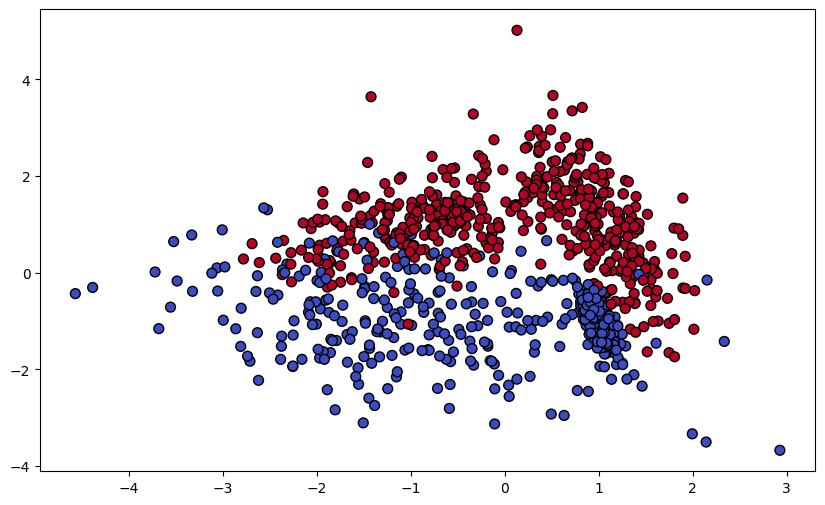

In [118]:
# plot data
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=50)


In [119]:
# https://github.com/HaykTarkhanyan/coder_moder/blob/main/ml/classification_accuracy_report.py
def get_classification_scores(model, X_train, X_test, y_train, y_test, threshold=0.5,
                              data_info=True, detailed=True, class_prob_distplot=True, 
                              positive_class="Churned", round_to=4, save_json=False, save_folder=None,
                              model_name=None):
    y_train_prob = model.predict_proba(X_train)[:,1]
    y_test_prob = model.predict_proba(X_test)[:,1]
    y_train_class = y_train_prob > threshold
    y_test_class = y_test_prob > threshold
    
    
    metrics = {
        "datetime": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        'model': model, 
        "model_name": model.__class__.__name__,
        "Accuracy train:":accuracy_score(y_train, y_train_class),
        "Accuracy test:":accuracy_score(y_test, y_test_class),
        "Average Precision train:": average_precision_score(y_train, y_train_class),
        "Average Precision test:": average_precision_score(y_test, y_test_class),
        "ROC AUC train:":roc_auc_score(y_train, y_train_class),
        "ROC AUC test:":roc_auc_score(y_test, y_test_class),
    }
    
    metrics["Overfitting"] = metrics["ROC AUC train:"] - metrics["ROC AUC test:"]
    
    if detailed:
        metrics.update({
        "F1 train:":f1_score(y_train, y_train_class),
        "F1 test:":f1_score(y_test, y_test_class),
        "Precision train:":precision_score(y_train, y_train_class),
        "Precision test:":precision_score(y_test, y_test_class),
        "Recall train:":recall_score(y_train, y_train_class),
        "Recall test:":recall_score(y_test, y_test_class)
        })
    
        
    if data_info:
        metrics.update({
            "Train rows": len(y_train),
            "Columns": X_train.shape[1],
            "Test rows": len(y_test),
            "Train positive class %": y_train.mean(),
            "Test positive class %": y_test.mean()
        })
    
    if class_prob_distplot:
        fig = plt.figure(figsize=(6,3))
        plt.title(f'Model: {model.__class__.__name__} - Probability Distribution')
        sns.distplot(y_test_prob[y_test==0],label=f'not {positive_class}', color='green')
        sns.distplot(y_test_prob[y_test==1],label=positive_class)
        plt.legend()    
        plt.show()
        metrics["plot"] = fig
        
    if round_to:
        metrics = {k: round(v, round_to) if isinstance(v, (int, float)) else v for k, v in metrics.items()}

    if save_json:
        keys_to_ignore = ["model", "plot"]
        
        path = f'{metrics["model_name"]}_metrics.json'
        if save_folder:
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            path = f'{save_folder}/{path}' if save_folder else path

        with open(path, 'w') as f:
            json.dump({k: v for k, v in metrics.items() if k not in keys_to_ignore}, f)

    if model_name:
        metrics["model_name"] = model_name

    return metrics

# Logistic regression with sklearn

In [120]:
logistic = LogisticRegression()

logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_test)

print(f'Logistic Regression Test Accuracy: {accuracy:.2f}')


Logistic Regression Test Accuracy: 0.90


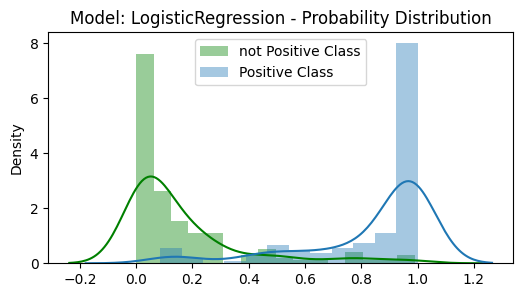

{'datetime': '2025-06-03 18:30:35',
 'model': LogisticRegression(),
 'model_name': 'Logistic Regression',
 'Accuracy train:': 0.8986,
 'Accuracy test:': 0.9,
 'Average Precision train:': 0.865,
 'Average Precision test:': 0.8526,
 'ROC AUC train:': 0.8987,
 'ROC AUC test:': 0.8988,
 'Overfitting': -0.0001,
 'F1 train:': 0.8996,
 'F1 test:': 0.8921,
 'Precision train:': 0.9086,
 'Precision test:': 0.9051,
 'Recall train:': 0.8908,
 'Recall test:': 0.8794,
 'plot': <Figure size 600x300 with 1 Axes>}

In [121]:
get_classification_scores(logistic, X_train, X_test, y_train, y_test,
                          threshold=0.5, data_info=False, detailed=True,
                          class_prob_distplot=True, positive_class="Positive Class",
                          round_to=4, save_json=False, save_folder=None,
                          model_name="Logistic Regression")

In [124]:
def plot_decision_boundary(model, X, y, title='Decision Boundary', points=100):
    """
    Plot the decision boundary for a 2D classification model
    
    Parameters:
    -----------
    model : sklearn classifier object
        The trained classifier
    X : array-like of shape (n_samples, 2)
        The input features
    y : array-like of shape (n_samples,)
        The target values
    title : str, default='Decision Boundary'
        The title of the plot
    """
    # Create a mesh grid
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), points),
                        np.linspace(X[:, 1].min(), X[:, 1].max(), points))
    
    # Predict for each point in mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training points
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

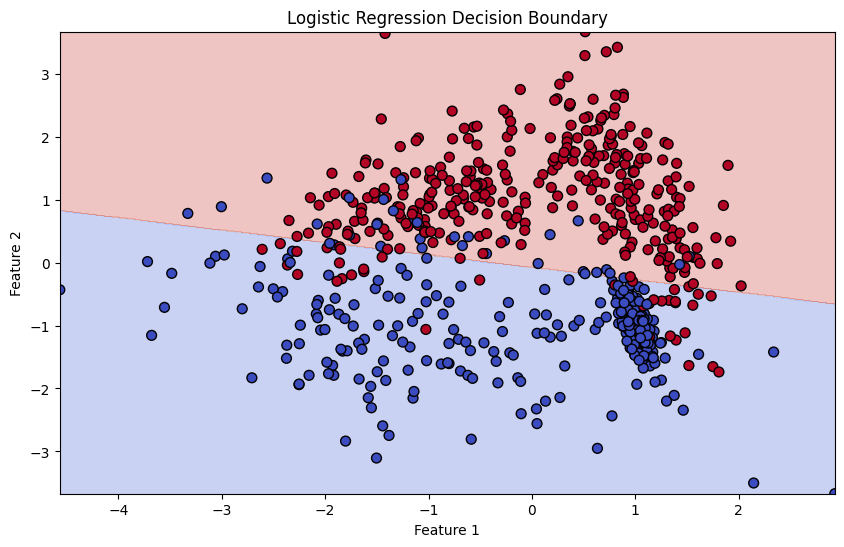

In [127]:
plot_decision_boundary(logistic, X_train, y_train,
                       title='Logistic Regression Decision Boundary',
                       points=500)

# Decision tree classifier

In [128]:
dt_default = DecisionTreeClassifier(random_state=509)
dt_default.fit(X_train, y_train)

y_pred_default = dt_default.predict(X_test)

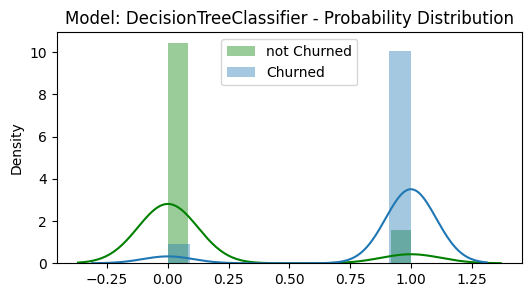

{'datetime': '2025-06-03 18:35:57',
 'model': DecisionTreeClassifier(random_state=509),
 'model_name': 'DecisionTreeClassifier',
 'Accuracy train:': 1.0,
 'Accuracy test:': 0.89,
 'Average Precision train:': 1.0,
 'Average Precision test:': 0.8268,
 'ROC AUC train:': 1.0,
 'ROC AUC test:': 0.8914,
 'Overfitting': 0.1086,
 'F1 train:': 1.0,
 'F1 test:': 0.8866,
 'Precision train:': 1.0,
 'Precision test:': 0.86,
 'Recall train:': 1.0,
 'Recall test:': 0.9149,
 'Train rows': 700,
 'Columns': 2,
 'Test rows': 300,
 'Train positive class %': 0.51,
 'Test positive class %': 0.47,
 'plot': <Figure size 600x300 with 1 Axes>}

In [129]:
get_classification_scores(dt_default, X_train, X_test, y_train, y_test,
                            threshold=0.5, data_info=True, detailed=True)

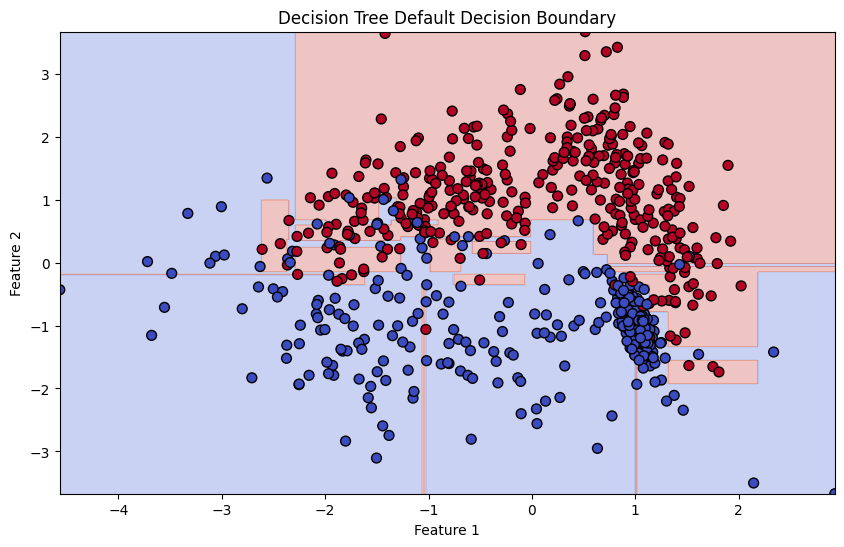

In [132]:
plot_decision_boundary(dt_default, X_train, y_train,
                       title='Decision Tree Default Decision Boundary',
                       points=500)

In [133]:
def get_tree(model):
    plot_tree(
        decision_tree=model,
        max_depth=15,
        feature_names=["Feature 1", "Feature 2"],
        class_names=["Class 0", "Class 1"],
        filled=True,
    )


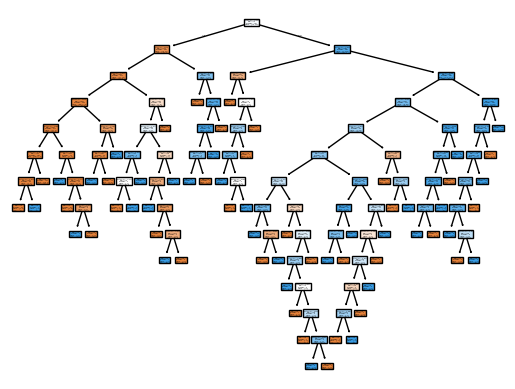

In [134]:
get_tree(dt_default)

# Restricted tree

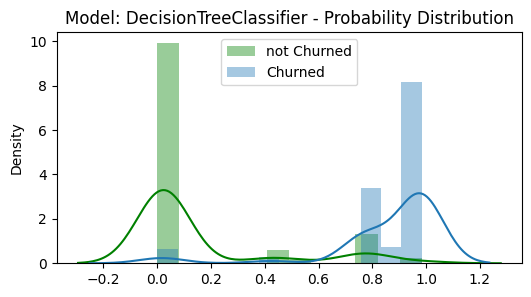

{'datetime': '2025-06-03 18:41:15',
 'model': DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=509),
 'model_name': 'DecisionTreeClassifier',
 'Accuracy train:': 0.9286,
 'Accuracy test:': 0.9,
 'Average Precision train:': 0.8944,
 'Average Precision test:': 0.8394,
 'ROC AUC train:': 0.9282,
 'ROC AUC test:': 0.9016,
 'Overfitting': 0.0266,
 'F1 train:': 0.9311,
 'F1 test:': 0.8973,
 'Precision train:': 0.916,
 'Precision test:': 0.8675,
 'Recall train:': 0.9468,
 'Recall test:': 0.9291,
 'Train rows': 700,
 'Columns': 2,
 'Test rows': 300,
 'Train positive class %': 0.51,
 'Test positive class %': 0.47,
 'plot': <Figure size 600x300 with 1 Axes>}

In [135]:
dt_tuned = DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=509)

dt_tuned.fit(X_train, y_train)
y_pred_tuned = dt_tuned.predict(X_test)

get_classification_scores(dt_tuned, X_train, X_test, y_train, y_test,
                            threshold=0.5, data_info=True, detailed=True)

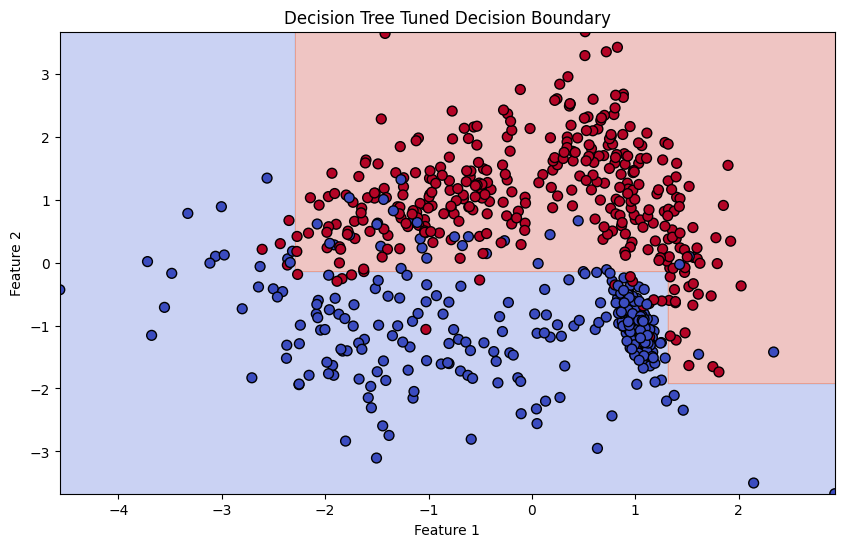

In [136]:
plot_decision_boundary(dt_tuned, X_train, y_train,
                       title='Decision Tree Tuned Decision Boundary',
                       points=500)

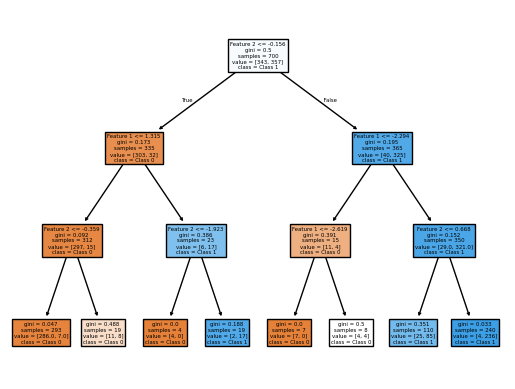

In [137]:
get_tree(dt_tuned)

# Random forest

In [138]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=2)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


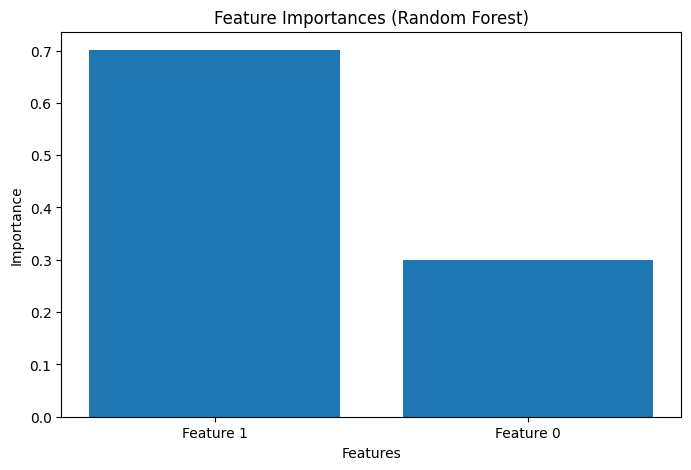

In [143]:


# Feature Importances from Random Forest
features = [f"Feature {i}" for i in range(X.shape[1])]
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()



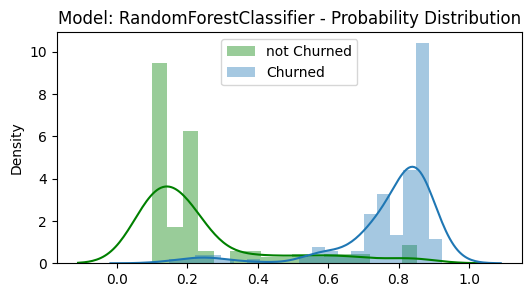

{'datetime': '2025-06-03 18:53:30',
 'model': RandomForestClassifier(max_depth=2, random_state=42),
 'model_name': 'RandomForestClassifier',
 'Accuracy train:': 0.9286,
 'Accuracy test:': 0.9067,
 'Average Precision train:': 0.8934,
 'Average Precision test:': 0.8466,
 'ROC AUC train:': 0.9281,
 'ROC AUC test:': 0.9087,
 'Overfitting': 0.0194,
 'F1 train:': 0.9313,
 'F1 test:': 0.9048,
 'Precision train:': 0.9137,
 'Precision test:': 0.8693,
 'Recall train:': 0.9496,
 'Recall test:': 0.9433,
 'plot': <Figure size 600x300 with 1 Axes>}

In [139]:
get_classification_scores(rf, X_train, X_test, y_train, y_test,
                           threshold=0.5, data_info=False, detailed=True)


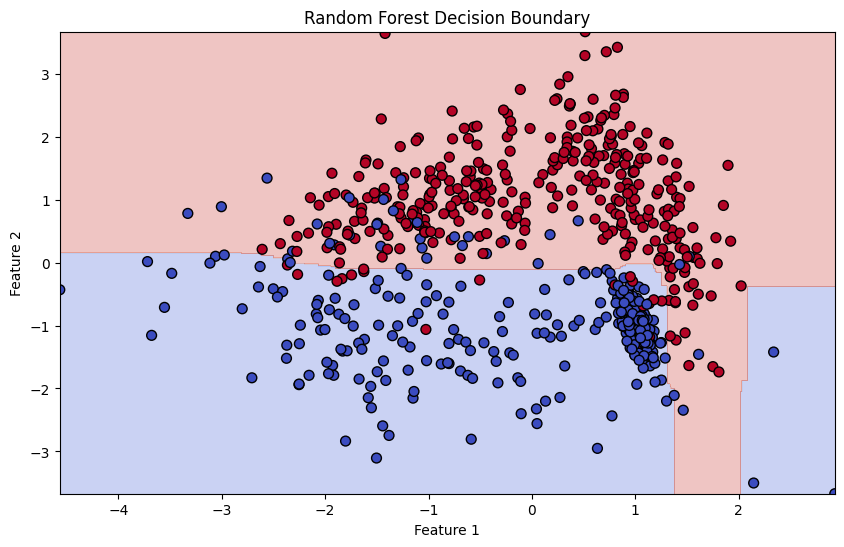

In [142]:
plot_decision_boundary(rf, X_train, y_train,
                       title='Random Forest Decision Boundary',
                       points=1_000)


# Boosting with lightgbm

In [ ]:
# 1) Install dependencies (if not already):
#    pip install lightgbm pandas scikit-learn
import kagglehub
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 2) Load the Kaggle CSV (assumes 'winequality-red.csv' is in your working directory)
# df = pd.read_csv("winequality-red.csv")
# kagglehub.install("uci/wine-quality-red")

df = pd.read_csv("winequality-red.csv")

# 3) Separate features/target
#    All columns except 'quality' are numeric predictors; 'quality' is a score from 0–10.
X = df.drop("quality", axis=1)
y = df["quality"]

# 4) Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5) Create LightGBM dataset objects
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val,   label=y_val, reference=lgb_train)

# 6) Set up parameters for a regression task (predict wine quality)
params = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42,
}

# 7) Train with early stopping
bst = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "valid"],
    early_stopping_rounds=50,
    verbose_eval=50,
)

# 8) Evaluate on the validation set
y_val_pred = bst.predict(X_val, num_iteration=bst.best_iteration)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f"Validation RMSE: {rmse:.4f}")

# 9) If desired, retrain on the full dataset before final predictions
#    (e.g., before scoring on a holdout "test.csv")
lgb_all = lgb.Dataset(X, label=y)
bst_final = lgb.train(
    params,
    lgb_all,
    num_boost_round=bst.best_iteration  # reuse the best number of rounds
)

# 10) Example: Predict on new samples (here we reuse X_val as a placeholder)
example_preds = bst_final.predict(X_val)
print("First 10 predictions:", example_preds[:10])


AttributeError: module 'kagglehub' has no attribute 'download'

In [ ]:
kagglehub.datasets.

AttributeError: module 'kagglehub.datasets' has no attribute 'download'